Import data

In [22]:
import datetime as dt
import numpy as np
import SEB_functions as SEBf
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Reading and selecting the data 

In [23]:
station = "AWS15"
dtime = "daily"     #'daily' or 'hourly'

# Options Greenland:
# S5 27-08-2003 - 24-08-2023
# S6 29-08-2003 - 21-08-2023
# S9 23-08-2000 - 21-08-2023
# S10 17-08-2010 - 17-04-2026
# Options Antarctica:
# AWS14 21-01-2009 - 01-01-2023
# AWS15 21-09-2009 - 24-06-2014
# AWS17 19-02-2011 - 10-03-2016
# AWS18 25-11-2014 - 02-12-2022

if station == "S5" or station == "S6" or station == "S9" or station == "S10":
    SEBdata = SEBf.SEB_data(FileName="../data/GRL_"+ station +"_"+dtime+"_all.csv")
elif station == "AWS14" or station == "AWS15" or station == "AWS17" or station == "AWS18":     
    SEBdata = SEBf.SEB_data(FileName="../data/ANT_"+ station +"_"+dtime+"_all.csv")

The header has  57 entries.
AWS file 'ANT_AWS15_daily_all.csv' has  1981 lines of data for 55 variables, start reading it.
now start reading the data
Reading completed.


Extract variables

In [24]:
SWdown = SEBdata.Extract_Variable("SWd") # from observations
SWup   = SEBdata.Extract_Variable("SWu") # from observations
SWnet  = SWdown - SWup
LWdown = SEBdata.Extract_Variable("LWd") # from observations
LWup   = SEBdata.Extract_Variable("LWu") # from observations
LWup_mod = SEBdata.Extract_Variable("LWu_mod") # from modeled TS
LWnet  = LWdown - LWup_mod
SHF    = SEBdata.Extract_Variable("SHFdown_mod") # calculated with MO using modeled TS
LHF    = SEBdata.Extract_Variable("LHFdown_mod") # calculated with MO using modeled TS
Gs     = SEBdata.Extract_Variable("GHFup_mod") # calculated using modelled TS
MeltS  = SEBdata.Extract_Variable("meltE") # calculated using modelled TS
MeltT  = MeltS  #SEBdata.Extract_Variable("totm_nrg") #not available is melt including subsurface when implementing radiation penetration
Residu = SWnet + LWnet + SHF + LHF + Gs - MeltS # residu combines melt with non closure of energy terms
T2m    = SEBdata.Extract_Variable("t2m")
pressure=SEBdata.Extract_Variable("p")
ff10m   = SEBdata.Extract_Variable("ff10m")
cloud_cover = SEBdata.Extract_Variable("cloud_cover")
Ts_mod = SEBdata.Extract_Variable("Ts_mod")
c_s=SHF/(ff10m*(T2m-Ts_mod)+1e-6) #correction factor to avoid division by zero

#remove nan values
indices_to_remove = ~np.isnan(cloud_cover)
cloud_cover=cloud_cover[indices_to_remove]
SWdown=SWdown[indices_to_remove]
SWup=SWup[indices_to_remove]
LWdown=LWdown[indices_to_remove]
LWup=LWup[indices_to_remove]
SHF=SHF[indices_to_remove]
LHF=LHF[indices_to_remove]
Gs=Gs[indices_to_remove]
Ts_mod=Ts_mod[indices_to_remove]
T2m=T2m[indices_to_remove]
ff10m=ff10m[indices_to_remove]
MeltS=MeltS[indices_to_remove]
Residu=Residu[indices_to_remove]
c_s=c_s[indices_to_remove]
SEBdata.DateTime=SEBdata.DateTime[indices_to_remove]

print('Average cloud cover: ',np.mean(cloud_cover))




Average cloud cover:  0.6621728778467909


Lineare regression for correlation

72.016588881149


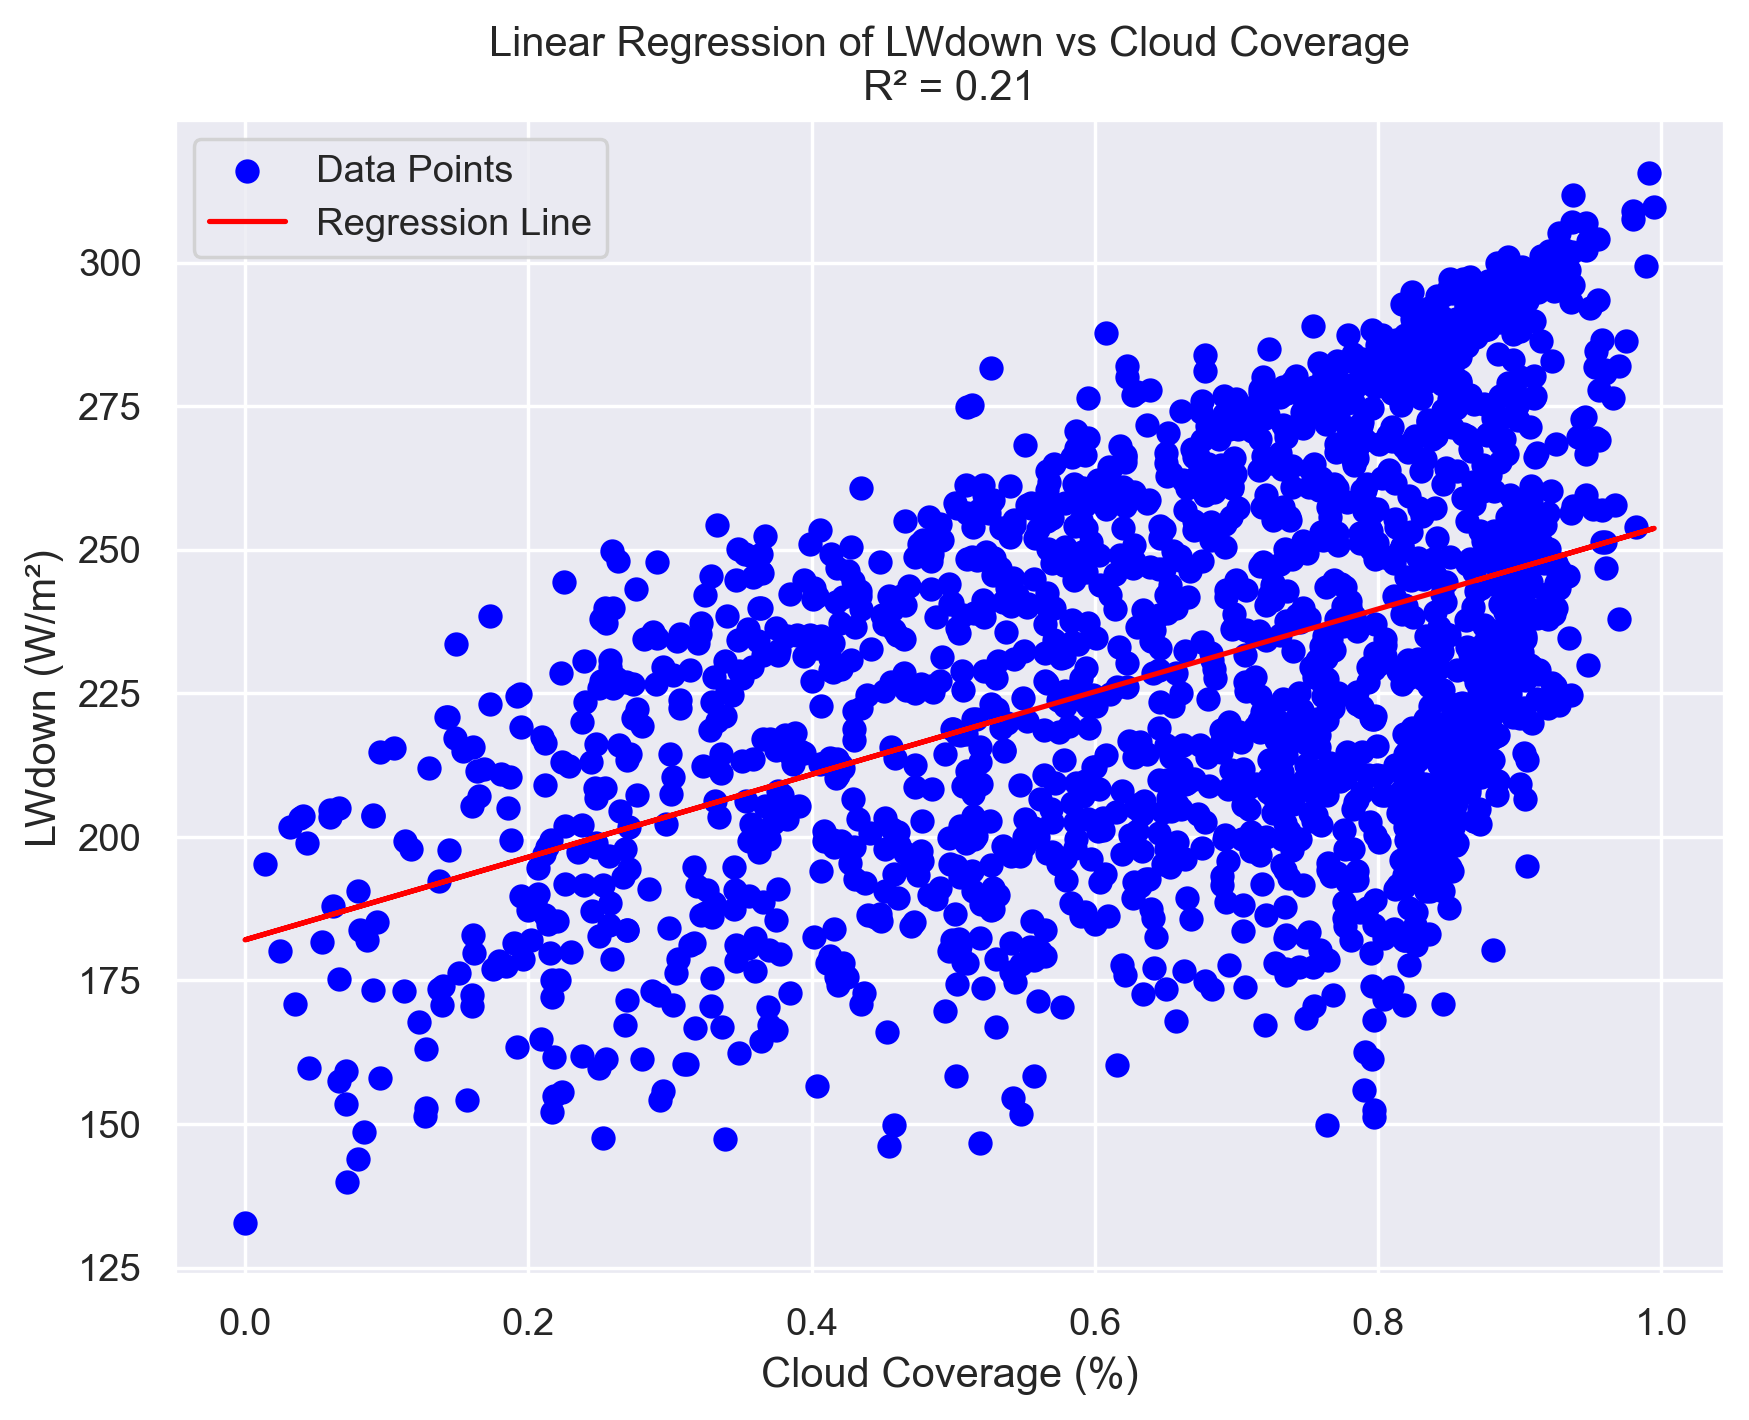

3.07428642035806


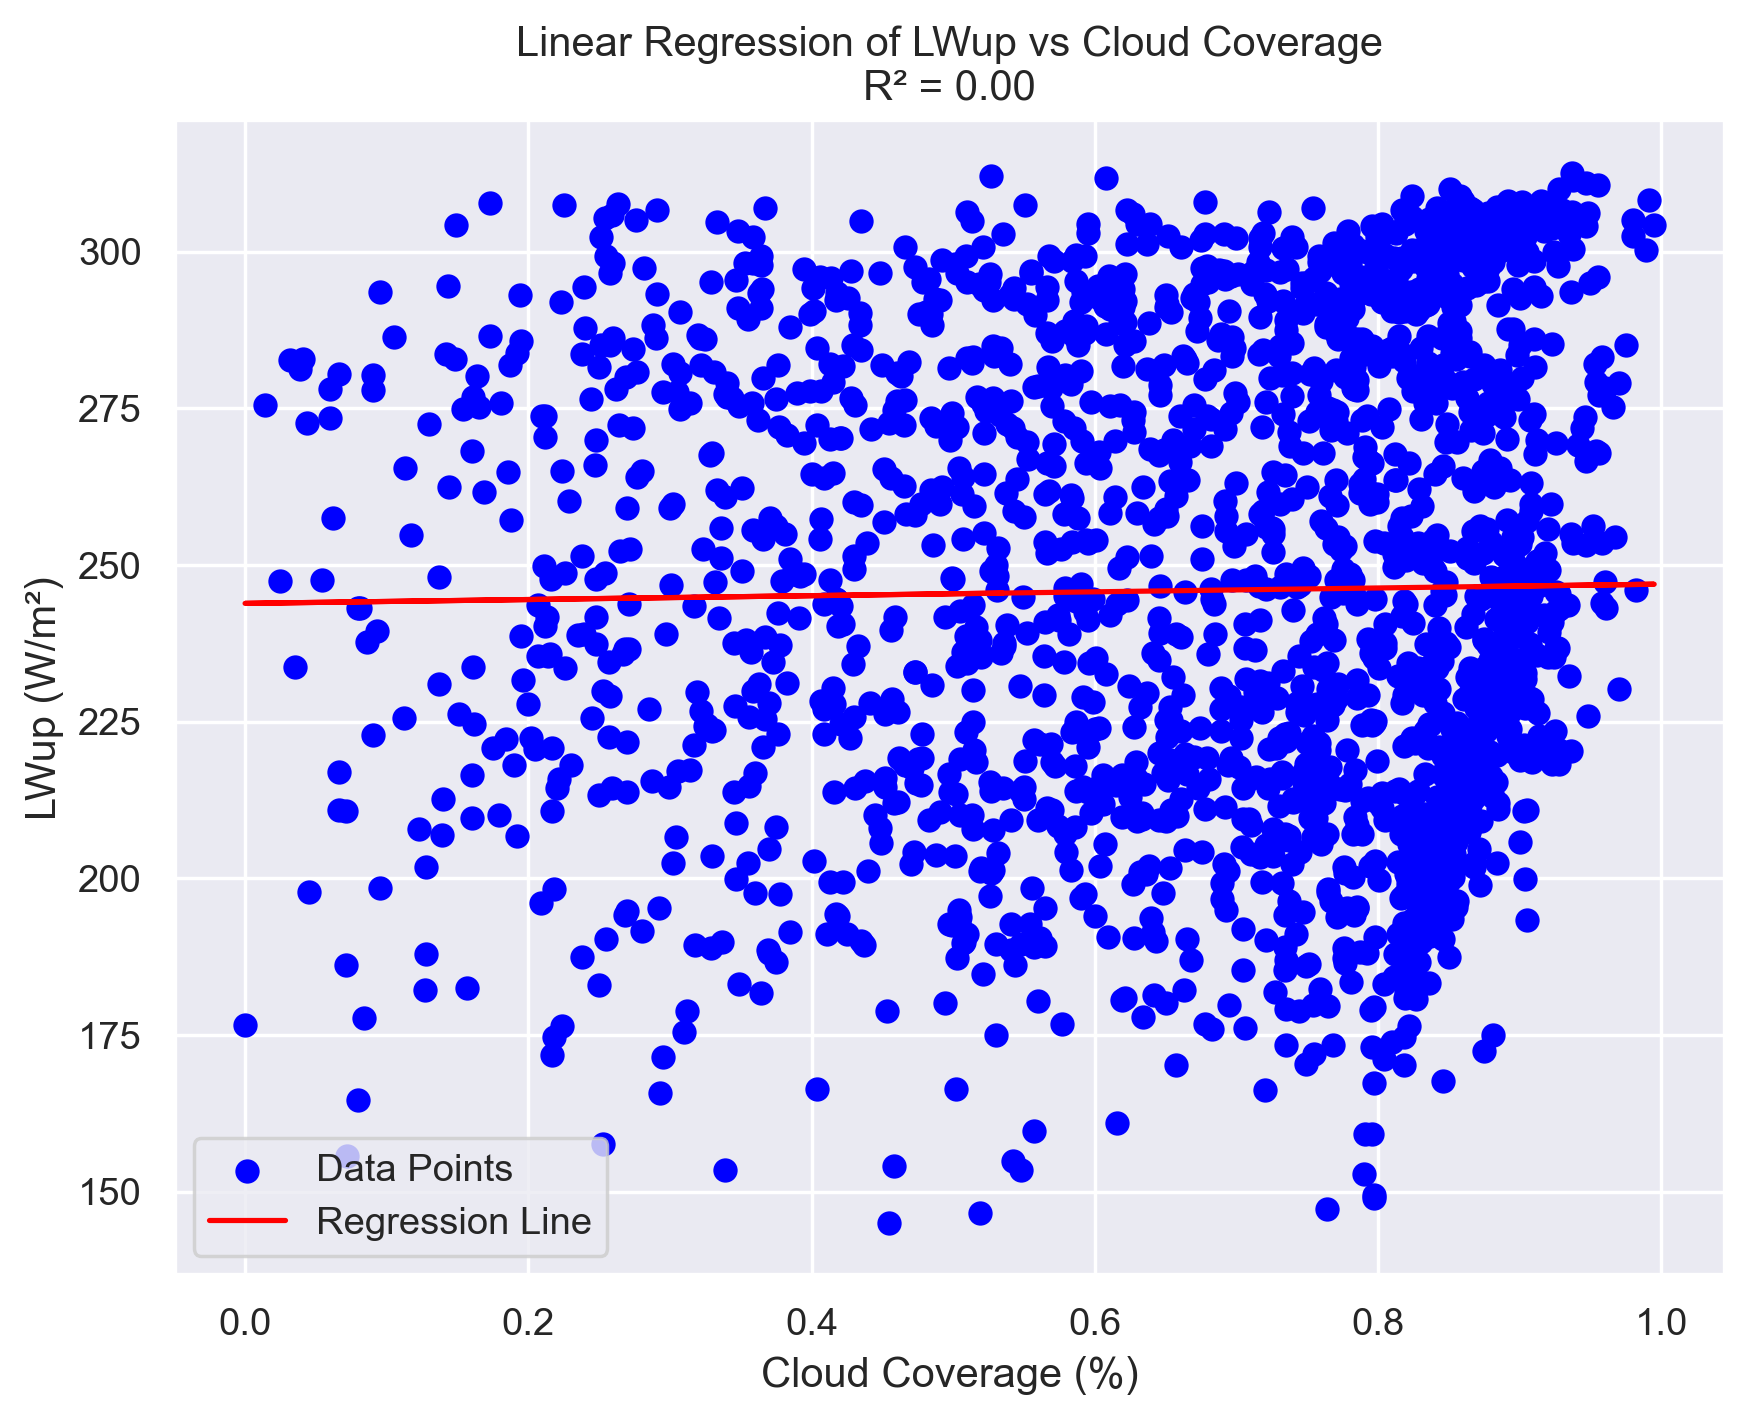

-149.11601296243003


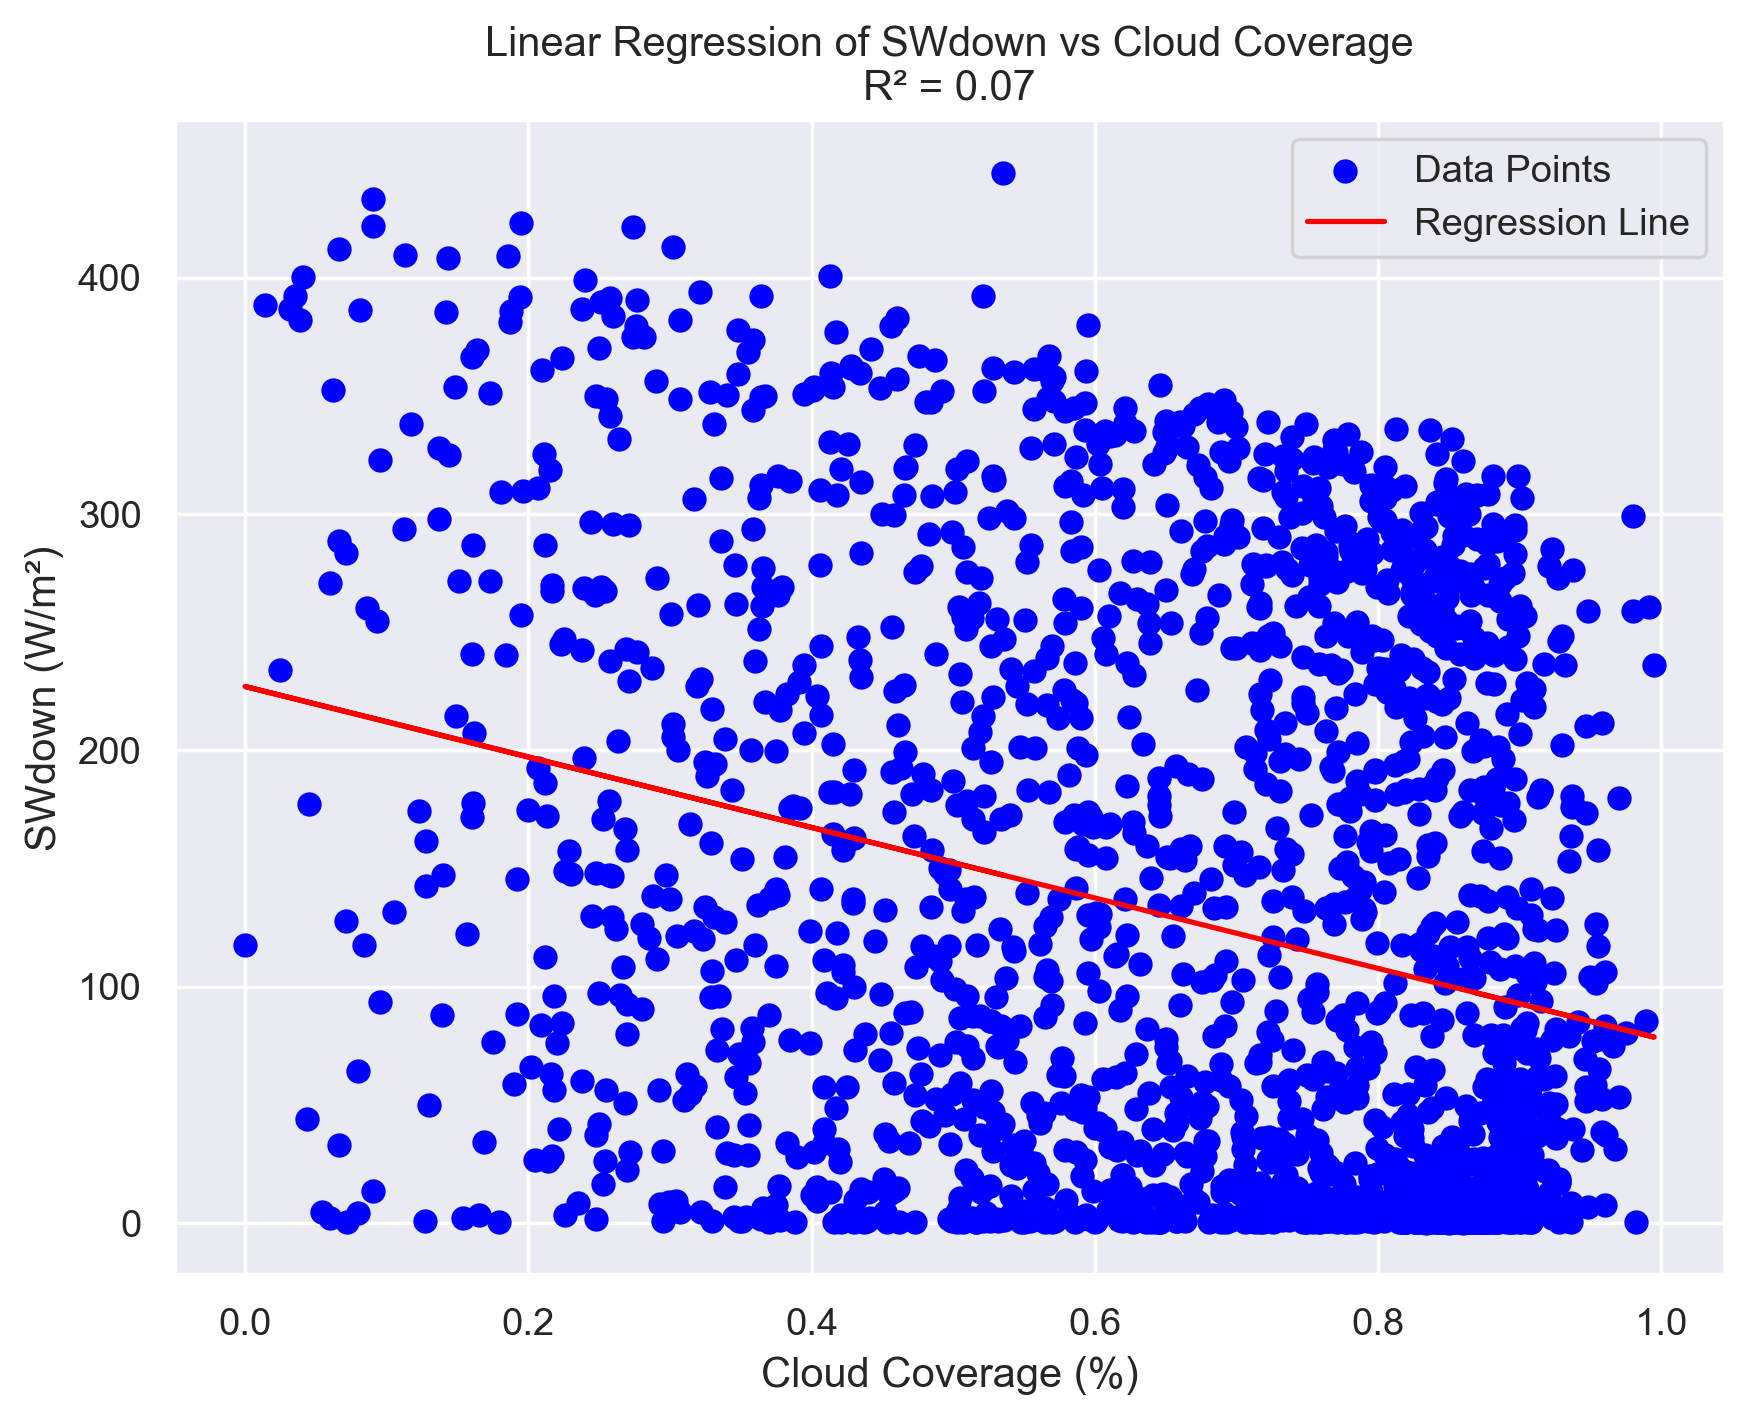

-117.98004931058209


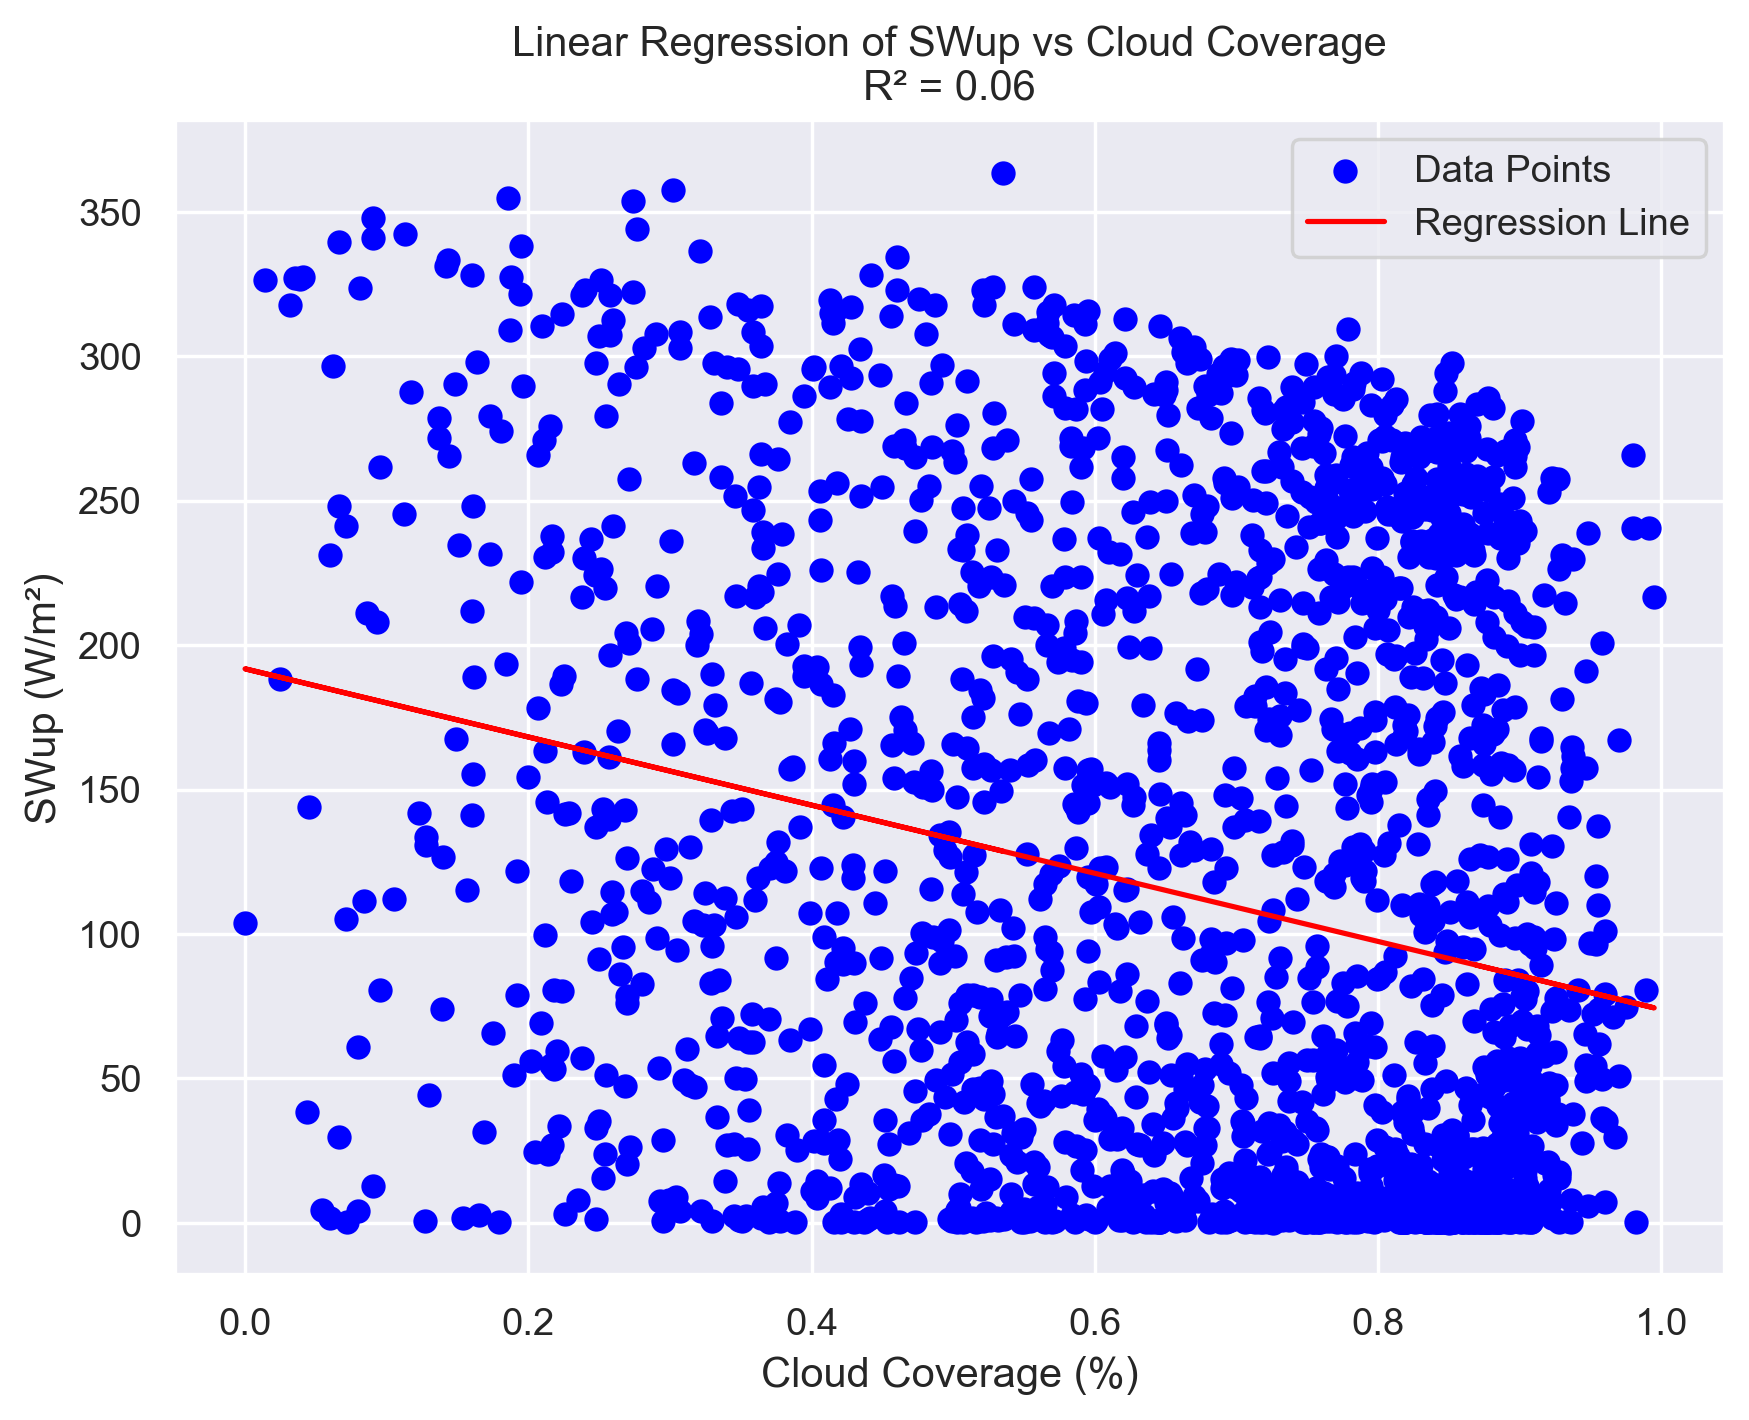

-23.196786032221347


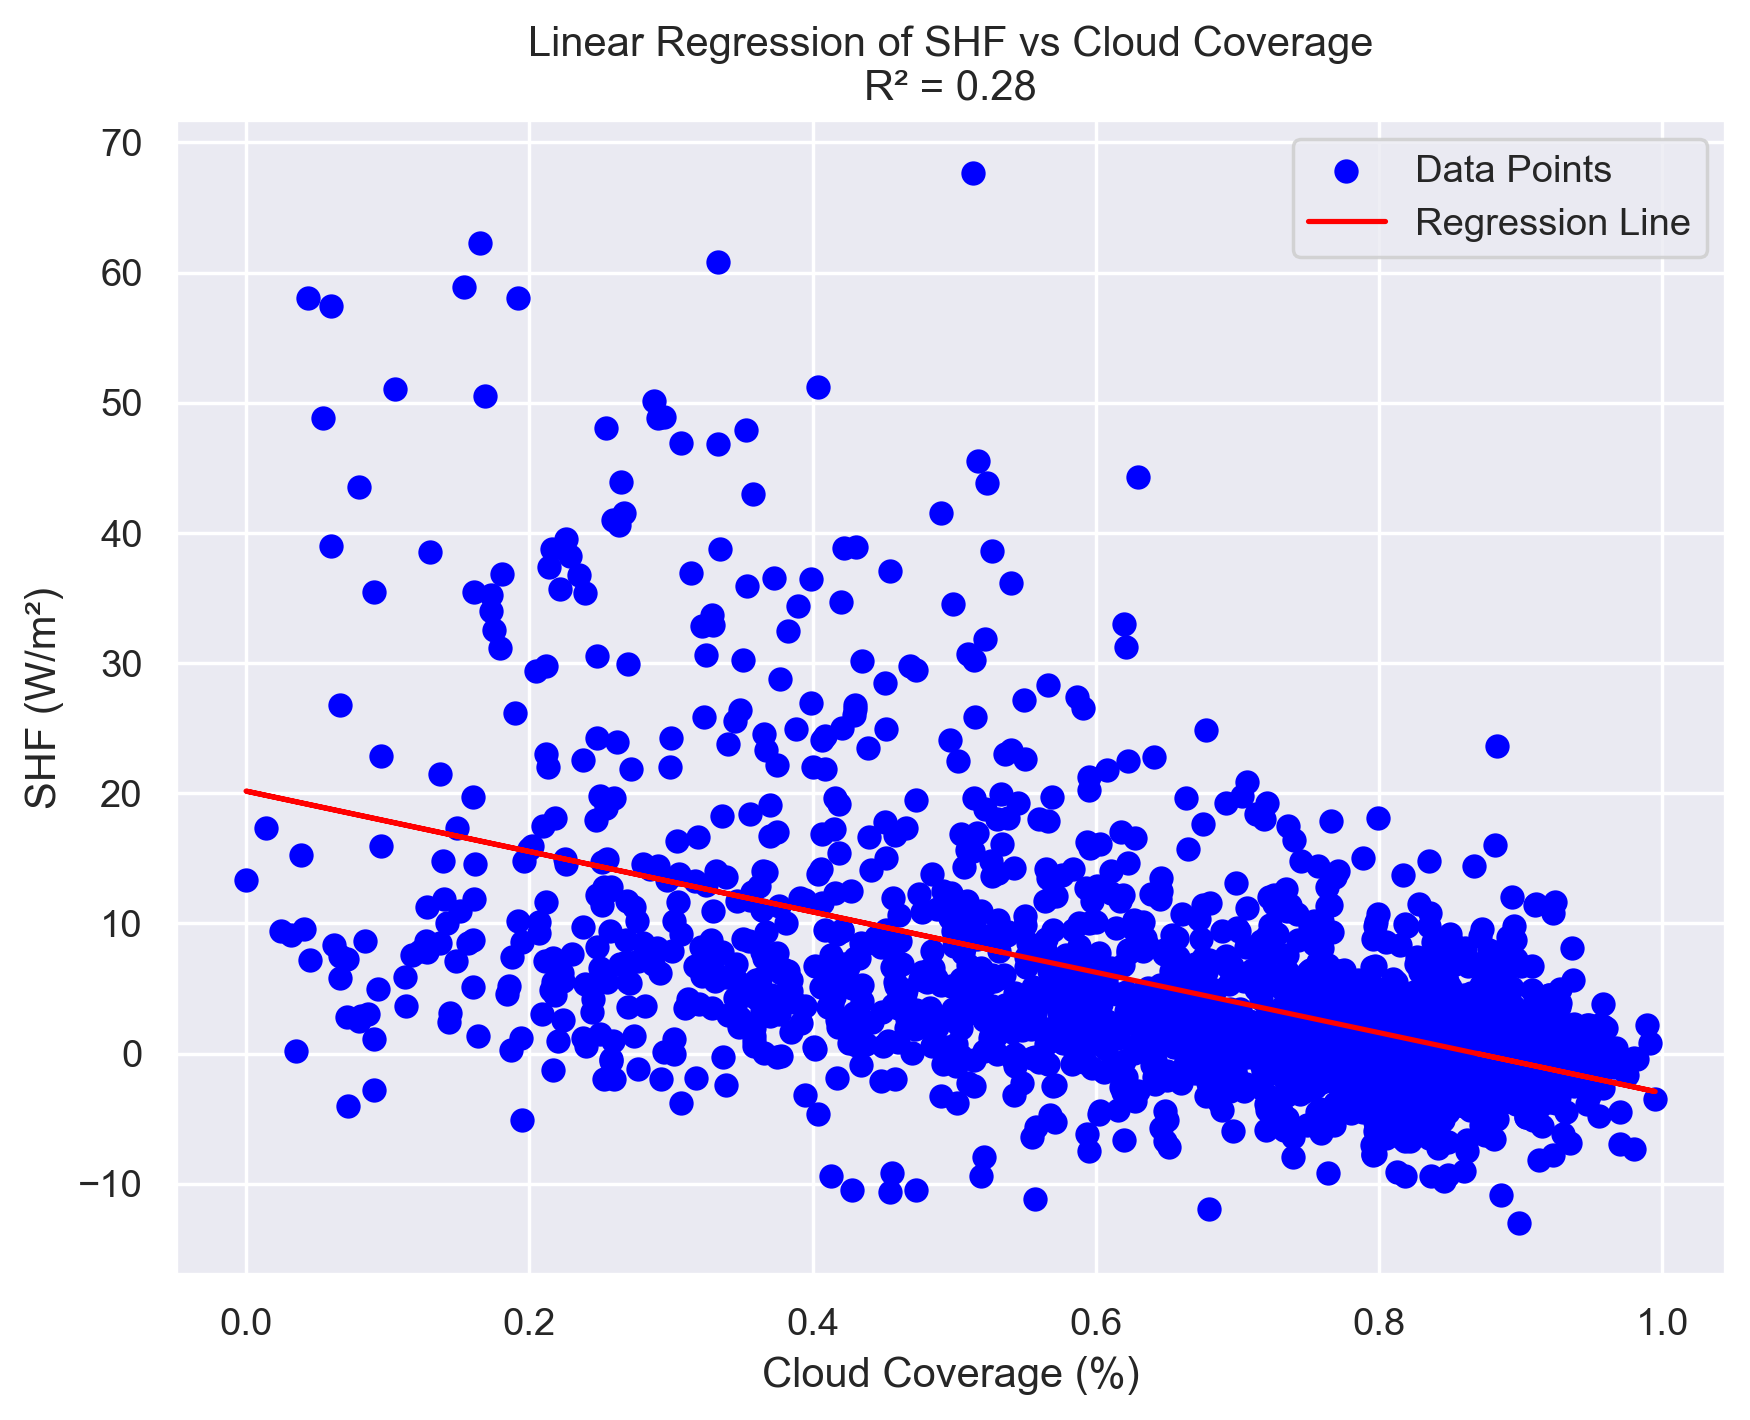

-4.230237278597347


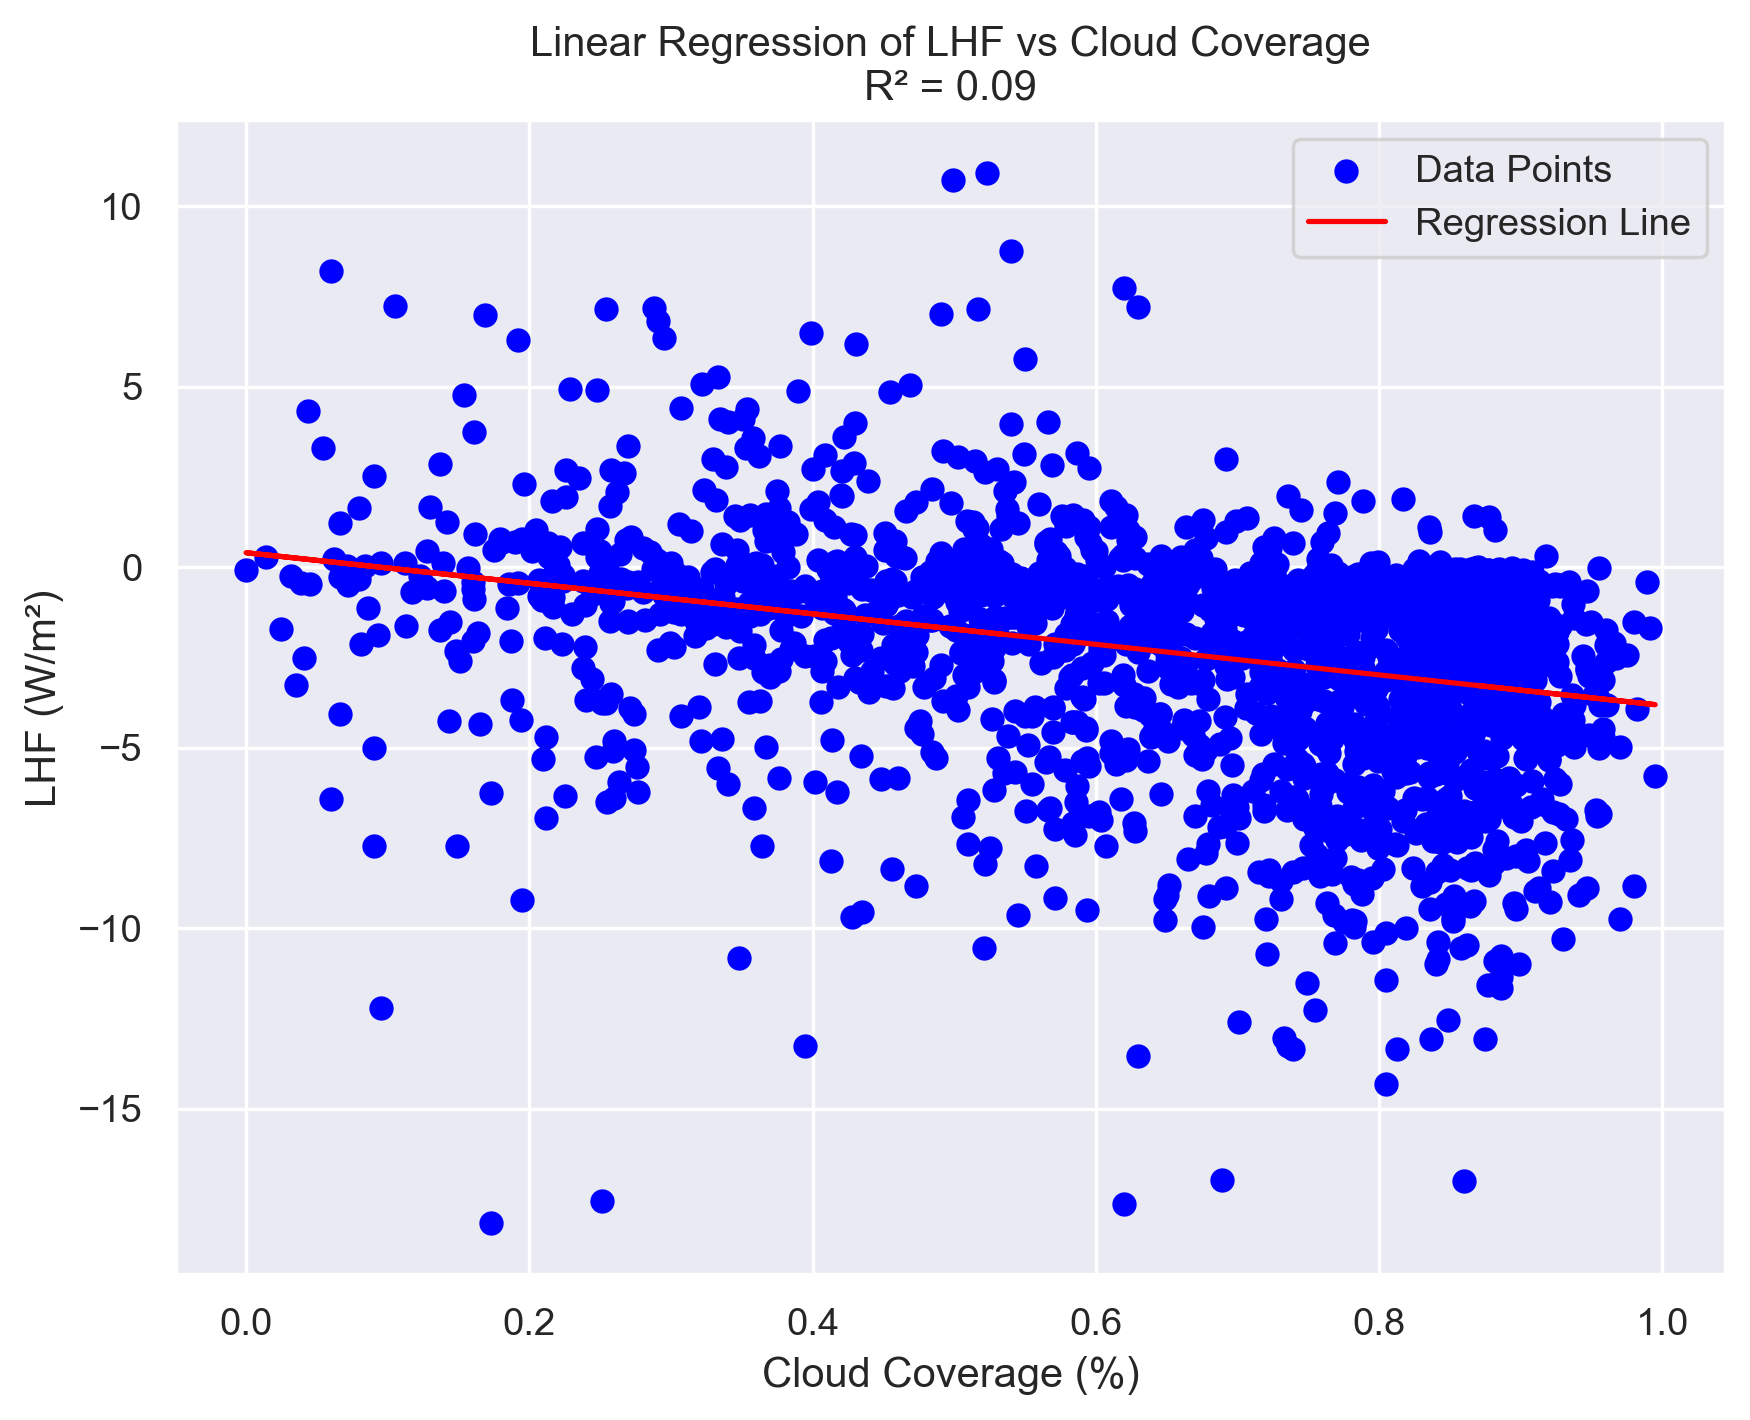

-7.677335064343831


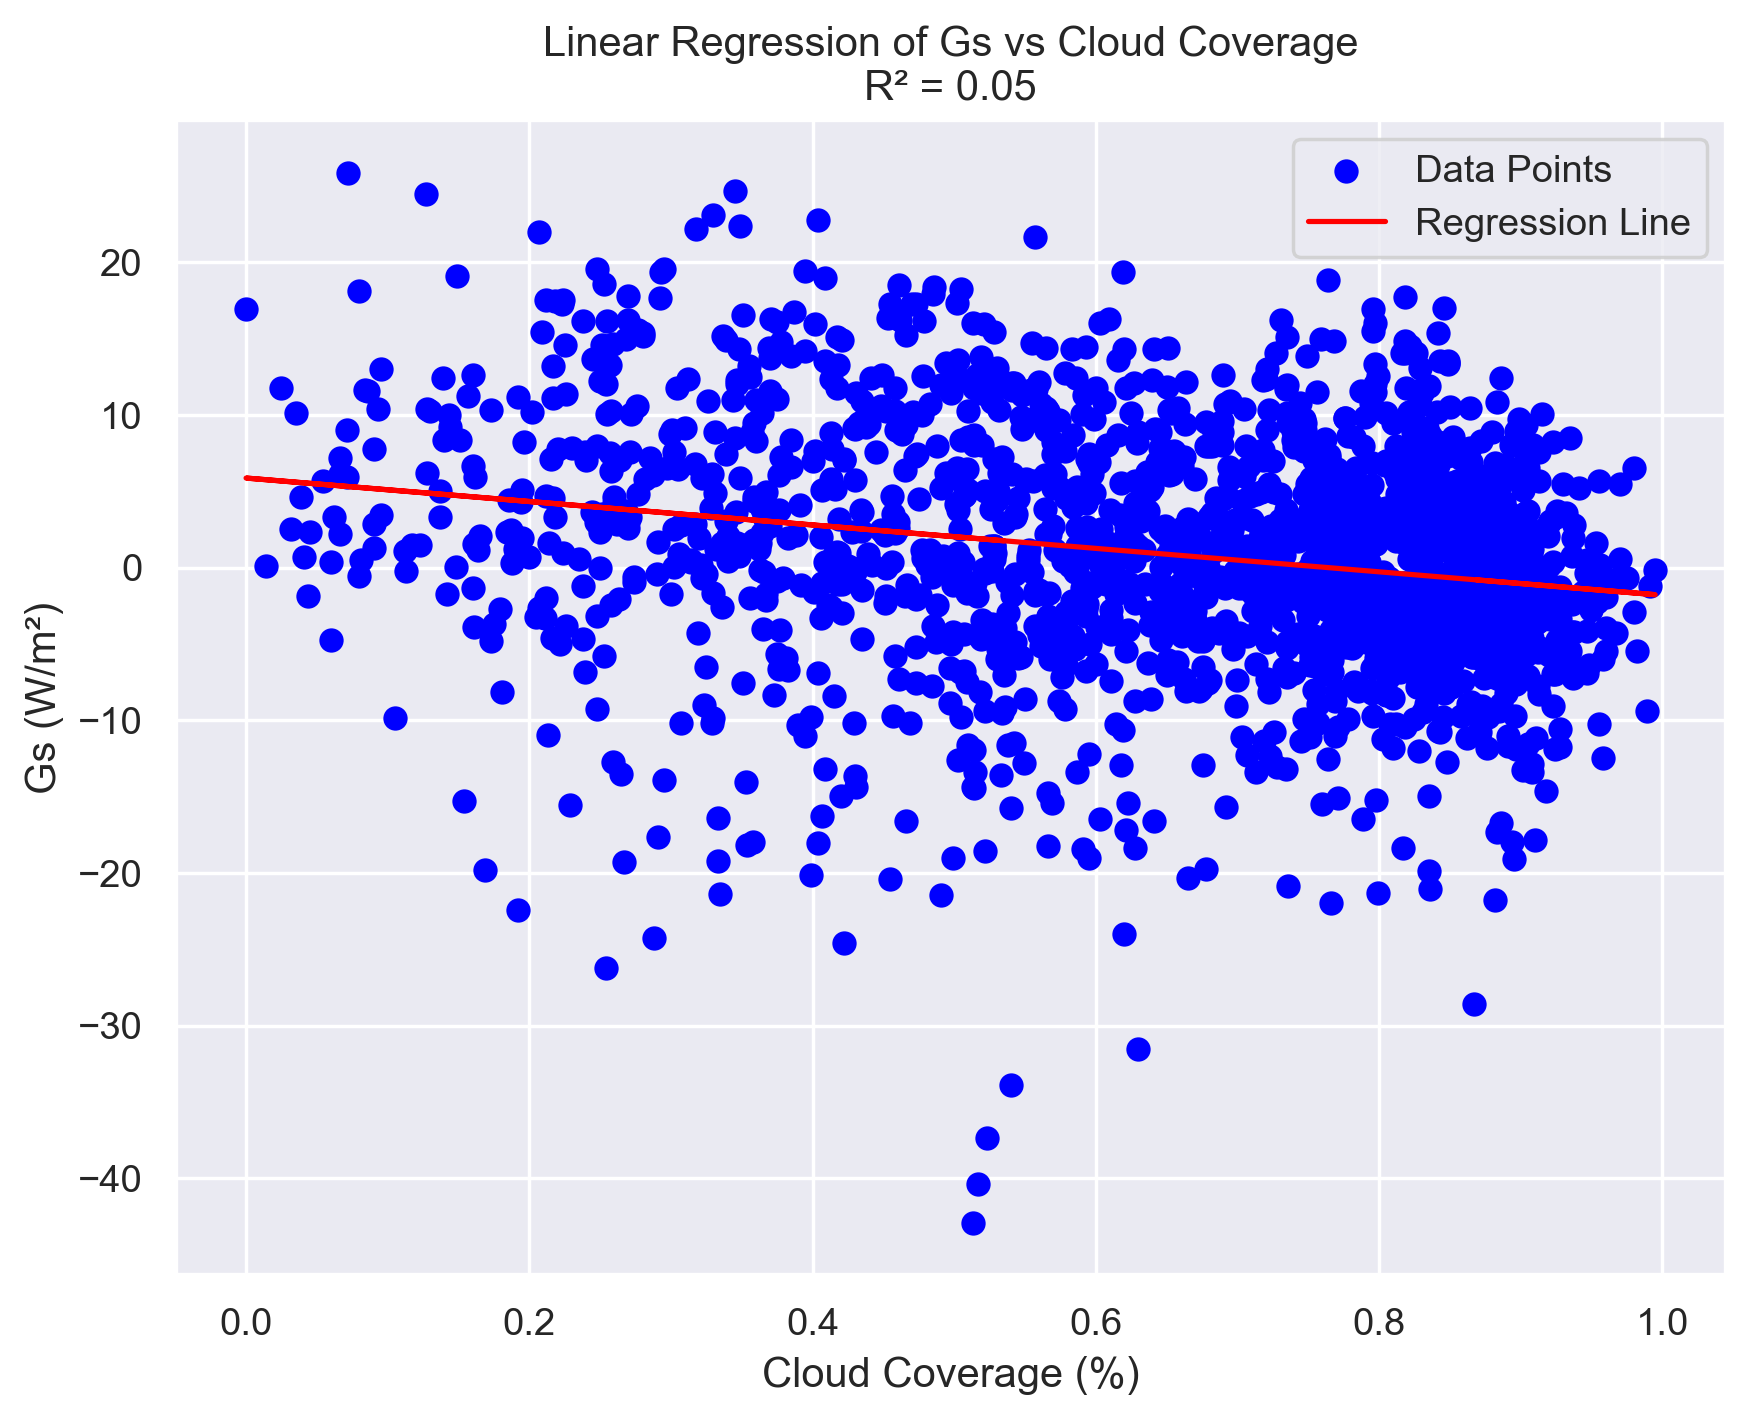

In [25]:


# Function to perform linear regression and plot results
def perform_linear_regression(x, y, x_label, y_label, title):
    model = LinearRegression()
    x = x.reshape(-1, 1)  # Reshape for sklearn
    model.fit(x, y)
    predictions = model.predict(x)

    slope = model.coef_[0]  
    # Calculate R-squared
    r_squared = r2_score(y, predictions)

    print(slope)

    # Plot the results
    plt.figure(figsize=(8, 6),dpi=250)
    plt.scatter(x, y, color='blue', label='Data Points')
    plt.plot(x, predictions, color='red', label='Regression Line')
    plt.title(f"{title}\nR² = {r_squared:.2f}")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"../results/figures/regression/{title}.png")
    plt.show()

    return slope

# Perform linear regression for each variable with respect to cloud coverage
slope_LWdown=perform_linear_regression(cloud_cover, LWdown, "Cloud Coverage (%)", "LWdown (W/m²)", "Linear Regression of LWdown vs Cloud Coverage")
slope_LWup=perform_linear_regression(cloud_cover, LWup, "Cloud Coverage (%)", "LWup (W/m²)", "Linear Regression of LWup vs Cloud Coverage")
slope_SWdown=perform_linear_regression(cloud_cover, SWdown, "Cloud Coverage (%)", "SWdown (W/m²)", "Linear Regression of SWdown vs Cloud Coverage")
slope_SWup=perform_linear_regression(cloud_cover, SWup, "Cloud Coverage (%)", "SWup (W/m²)", "Linear Regression of SWup vs Cloud Coverage")
slope_SHF=perform_linear_regression(cloud_cover, SHF, "Cloud Coverage (%)", "SHF (W/m²)", "Linear Regression of SHF vs Cloud Coverage")
slope_LHF=perform_linear_regression(cloud_cover, LHF, "Cloud Coverage (%)", "LHF (W/m²)", "Linear Regression of LHF vs Cloud Coverage")
slope_Gs=perform_linear_regression(cloud_cover, Gs, "Cloud Coverage (%)", "Gs (W/m²)", "Linear Regression of Gs vs Cloud Coverage")

#slope_Ts_mod=perform_linear_regression(cloud_cover, Ts_mod, "Cloud Coverage (%)", "Ts_mod (W/m²)", "Linear Regression of Ts_mod vs Cloud Coverage")



print slopes for test

In [26]:
print('Slope for LWdown:', slope_LWdown)
print('Slope for LWup:', slope_LWup)
print('Slope for SWdown:', slope_SWdown)
print('Slope for SWup:', slope_SWup)
print('Slope for SHF:', slope_SHF)
print('Slope for LHF:', slope_LHF)
print('Slope for Gs:', slope_Gs)

Slope for LWdown: 72.016588881149
Slope for LWup: 3.07428642035806
Slope for SWdown: -149.11601296243003
Slope for SWup: -117.98004931058209
Slope for SHF: -23.196786032221347
Slope for LHF: -4.230237278597347
Slope for Gs: -7.677335064343831


Adapt terms with regression coefficients

In [27]:
LWdown_original=LWdown.copy()
LWup_original=LWup.copy()
SWdown_original=SWdown.copy()
SWup_original=SWup.copy()
SHF_original=SHF.copy()
LHF_original=LHF.copy()
Gs_original=Gs.copy()
Ts_mod_original=Ts_mod.copy()

In [28]:

LWdown+=slope_LWdown*(1.0-cloud_cover)
LWup+=slope_LWup*(1.0-cloud_cover)
SWdown+=slope_SWdown*(1.0-cloud_cover)
SWup+=slope_SWup*(1.0-cloud_cover)
SHF+=slope_SHF*(1.0-cloud_cover)
LHF+=slope_LHF*(1.0-cloud_cover)
Gs+=slope_Gs*(1.0-cloud_cover)
SWdown[SWdown<0]=0
SWup[SWup<0]=0
LWdown[LWdown<0]=0
LWup[LWup<0]=0



solve the equation

In [29]:
#variables to track success/failures of the root finding algorithm
fail_bracket=0
fail_maxiter=0
fail_invalid_inputdata=0
success=0

#SEB equation. Can include or leave out melt and residual terms
def SEB_equation(Ts_mod,SWdown,SWup,LWdown,ff10m,T2m,LHF,Gs,MeltS,Residu,c_s,incl_melt=False,incl_residual=False):
    sigma = 5.67*10**-8
    LHS=0
    if incl_melt:
        LHS+=MeltS
    if incl_residual:
        LHS+=Residu
    RHS=SWdown-SWup+LWdown-sigma*(Ts_mod+273.16)**4+c_s*ff10m*(T2m-Ts_mod)+LHF+Gs
    return RHS-LHS

#bisection method for root finding
def find_root(func,x1,x2,args,tol=1e-6,N_max=100):
    global fail_bracket, fail_maxiter, success
    #check if the initial values are correct
    if (func(x1,*args)*func(x2,*args))>0:
        #print("Root not found: Initial values do not bracket the root")
        fail_bracket+=1
        return None
    #iterate
    i=0
    while i<N_max:
        x=(x1+x2)/2.0
        if func(x,*args)==0 or np.abs((x2-x1)/2.0)<tol:
            #print("Root found after",i,"iterations")
            success+=1
            return x
        if np.sign(func(x,*args))==np.sign(func(x1,*args)):
            x1=x
        if np.sign(func(x,*args))==np.sign(func(x2,*args)):
            x2=x
        i+=1
    print("Root not found: Maximum number of iterations reached")
    fail_maxiter+=1
    return None

#function to solve the SEB equation and retrun the the new T and M
def close_equation(func,T_init_1,T_init_2,args):
    new_temp=find_root(func,T_init_1,T_init_2,args)
    if new_temp is None:
        #print("No solution found")
        return np.nan, np.nan
    if new_temp>0:
        #print("Temperature is above zero degrees Celsius")
        new_temp=0
        melt=func(new_temp,*args)
        #print('T = 0°C')
        #print(f'M = {melt:.3f} W/m^2')
    else:
        melt=0
        #print(f'T = {new_temp:.3f}°C')
        #print('M = 0 W/m^2')
    return new_temp, melt

In [30]:
#solve the SEB equation for each given time step
T_solve=[]
M_solve=[]
for i in range(len(SWdown)):
    if (np.isnan(SWdown[i]) or np.isnan(SWup[i]) or np.isnan(LWdown[i]) or
        np.isnan(ff10m[i]) or np.isnan(T2m[i]) or np.isnan(LHF[i]) or
        np.isnan(Gs[i]) or np.isnan(MeltS[i]) or np.isnan(Residu[i]) or
        np.isnan(c_s[i])):
        fail_invalid_inputdata+=1
        T_solve.append(np.nan)
        M_solve.append(np.nan)
        continue    #skip iteration if any of the values is NaN
    args=[SWdown[i],SWup[i],LWdown[i],ff10m[i],T2m[i],LHF[i],Gs[i],MeltS[i],Residu[i],c_s[i]]
    T1_init,T2_init=Ts_mod[i]+50,Ts_mod[i]-50
    T,M=close_equation(SEB_equation,T1_init,T2_init,args)
    T_solve.append(T)
    M_solve.append(M)
T_solve=np.array(T_solve)
M_solve=np.array(M_solve)
print(f"Bracket failure: {fail_bracket}")
print(f"Maxiter failure: {fail_maxiter}")
print(f"Invalid input data: {fail_invalid_inputdata}")
print(f"Success: {success}")


Bracket failure: 14
Maxiter failure: 0
Invalid input data: 0
Success: 1918


In [31]:
#from here: Plot the results

#change data arrays to daily/monthly/avgmonthly for plotting. Also, create the according time data for x-axis
timestep='monthly' # 'daily', 'monthly', 'avgmonthly'
if timestep=='daily':
    f=SEBf.get_daily_average
    Time_data  = f(SHF, SEBdata.DateTime, GiveDatesBack=True)[1]
    Time_range  = [dt.datetime.fromisoformat("2012-01-01"), dt.datetime.fromisoformat("2013-01-01")]
    Time_Label  = "Date"
elif timestep=='monthly':
    f=SEBf.get_monthly_average
    Time_data  = f(SHF, SEBdata.DateTime, GiveDatesBack=True)[1]
    Time_range  = [SEBdata.DateTime[0], SEBdata.DateTime[-1]]
    Time_Label  = "Year"
elif timestep=='avgmonthly':
    f=SEBf.get_avg_monthly_value
    Time_data  = np.arange(14)
    Time_range  = [0, 12.5]
    Time_Label  = "Month"
SWdown=f(SWdown,SEBdata.DateTime)
SWup=f(SWup,SEBdata.DateTime)
LWdown=f(LWdown,SEBdata.DateTime)
LWup=f(LWup,SEBdata.DateTime)
ff10m=f(ff10m,SEBdata.DateTime)
T2m=f(T2m,SEBdata.DateTime)
LHF=f(LHF,SEBdata.DateTime)
SHF=f(SHF,SEBdata.DateTime)
Gs=f(Gs,SEBdata.DateTime)
MeltS=f(MeltS,SEBdata.DateTime)
Residu=f(Residu,SEBdata.DateTime)
c_s=f(c_s,SEBdata.DateTime)
Ts_mod=f(Ts_mod,SEBdata.DateTime)
cloud_cover=f(cloud_cover,SEBdata.DateTime)
T_solve=f(T_solve,SEBdata.DateTime)
M_solve=f(M_solve,SEBdata.DateTime)
LWdown_original=f(LWdown_original,SEBdata.DateTime)
LWup_original=f(LWup_original,SEBdata.DateTime)
SWdown_original=f(SWdown_original,SEBdata.DateTime)
SWup_original=f(SWup_original,SEBdata.DateTime)
SHF_original=f(SHF_original,SEBdata.DateTime)
LHF_original=f(LHF_original,SEBdata.DateTime)
Gs_original=f(Gs_original,SEBdata.DateTime)


#find NaN values and remove them
indices_to_remove = ~np.isnan(T_solve)
SWdown=SWdown[indices_to_remove]
SWup=SWup[indices_to_remove]
LWdown=LWdown[indices_to_remove]
LWup=LWup[indices_to_remove]
SHF=SHF[indices_to_remove]
ff10m=ff10m[indices_to_remove]
T2m=T2m[indices_to_remove]
LHF=LHF[indices_to_remove]
Gs=Gs[indices_to_remove]
MeltS=MeltS[indices_to_remove]
Residu=Residu[indices_to_remove]
c_s=c_s[indices_to_remove]
Ts_mod=Ts_mod[indices_to_remove]
T_solve=T_solve[indices_to_remove]
M_solve=M_solve[indices_to_remove]
Time_data=Time_data[indices_to_remove]
LWdown_original=LWdown_original[indices_to_remove]
LWup_original=LWup_original[indices_to_remove]
SWdown_original=SWdown_original[indices_to_remove]
SWup_original=SWup_original[indices_to_remove]
SHF_original=SHF_original[indices_to_remove]
LHF_original=LHF_original[indices_to_remove]
Gs_original=Gs_original[indices_to_remove]





In [32]:
print('Average increase in surface Temperature:',np.nanmean(T_solve-Ts_mod),'°C')
print('Average melt per day before:',np.nanmean(MeltS),'W/m^2')
print('Average melt per day after:',np.nanmean(M_solve),'W/m^2')
print('Average increase in melt per day:',np.nanmean(M_solve-MeltS),'W/m^2')

Average increase in surface Temperature: 1.7108927984957478 °C
Average melt per day before: 0.8107539723502305 W/m^2
Average melt per day after: 0.4675294191925806 W/m^2
Average increase in melt per day: -0.3432245531576498 W/m^2


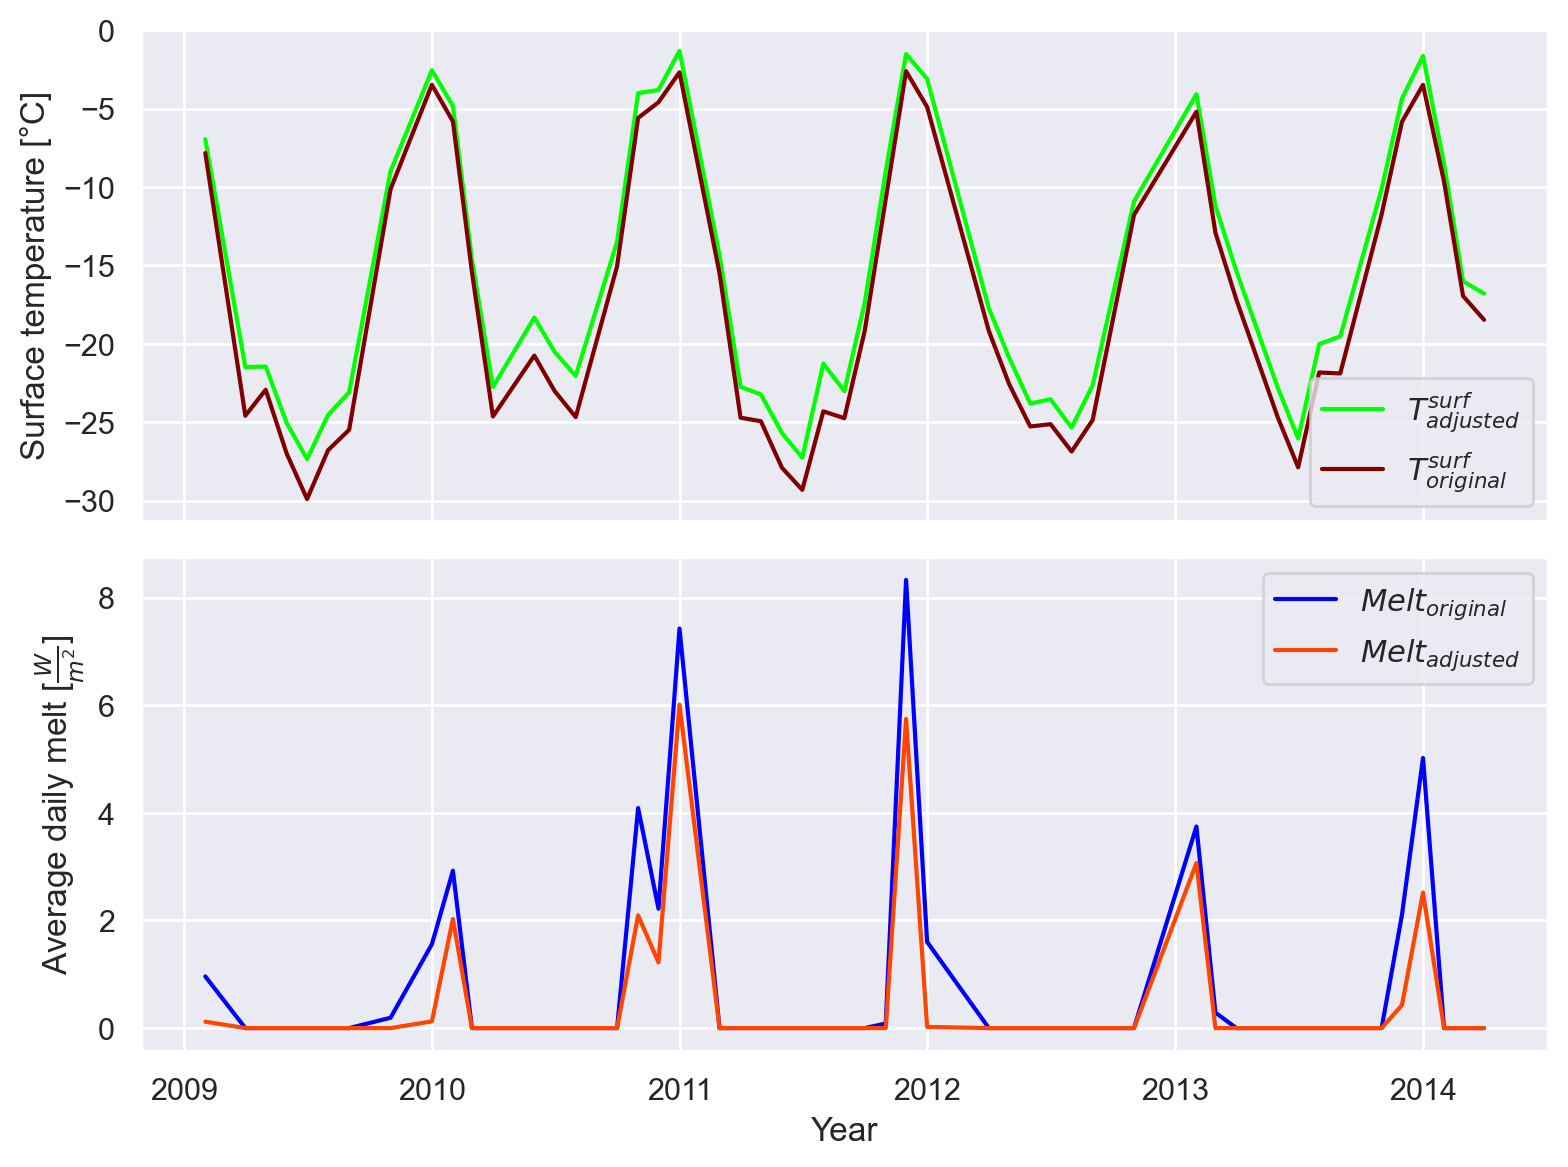

In [33]:
#compare visually the solved M,T with the original values from the data
fig, axs = plt.subplots(2,sharex=True,figsize=(8,6),dpi=200)
#fig.suptitle(f'Station: {station}, timestep:{timestep} ')
axs[0].set_ylabel('Surface temperature [°C]')
axs[0].plot(Time_data,T_solve,label=r'$T^{surf}_{adjusted}$',color='lime')
axs[0].plot(Time_data,Ts_mod,label=r'$T^{surf}_{original}$',color='maroon')
axs[0].legend()
axs[0].grid(True)
axs[1].set_ylabel(r'Average daily melt [$\frac{W}{m^2}$]')
axs[1].plot(Time_data,MeltS,label=r'$Melt_{original}$',color='blue')
axs[1].plot(Time_data,M_solve,label=r'$Melt_{adjusted}$',color='orangered')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel(Time_Label)
#axs[1].set_xlim(Time_range)
plt.tight_layout()
plt.savefig(f"../results/figures/adjust-always-cloudy/Temp_Melt_{timestep}.png")
plt.show()

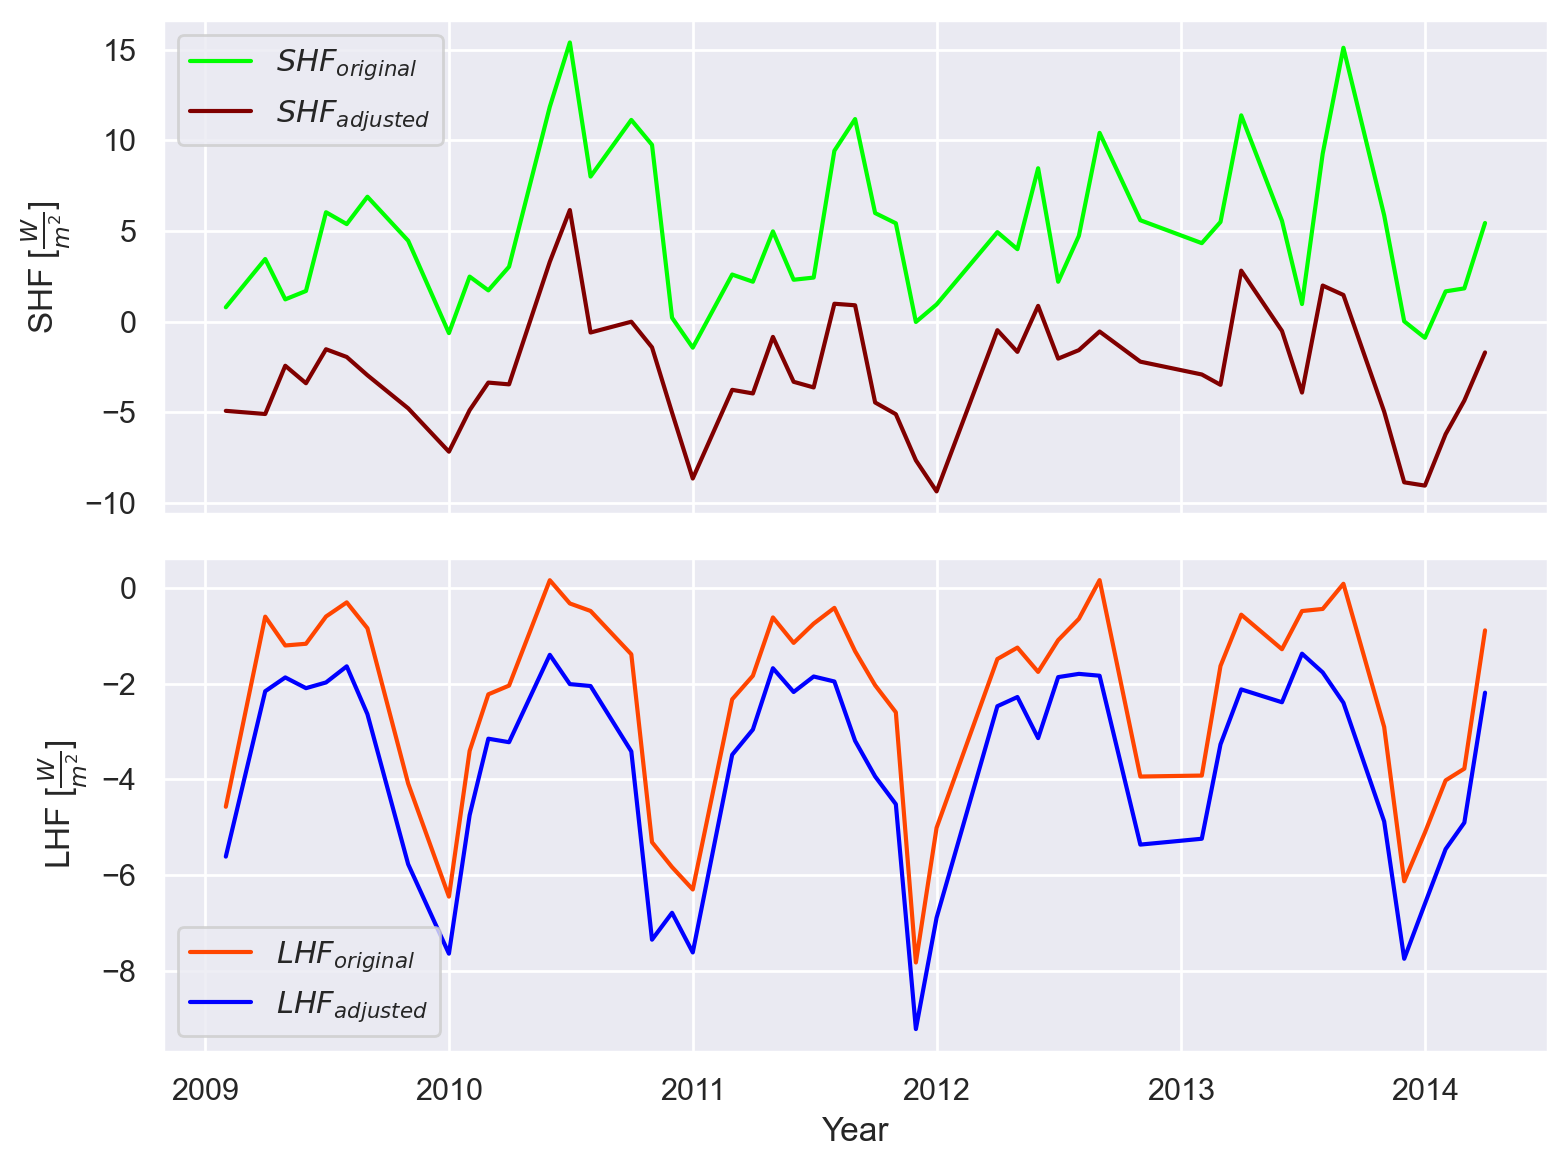

In [34]:
#plotting the SHF and LHF
fig, axs = plt.subplots(2,sharex=True,figsize=(8,6),dpi=200)
#fig.suptitle(f'Station: {station}, timestep:{timestep} ')
axs[0].set_ylabel(r'SHF [$\frac{W}{m^2}$]')
axs[0].plot(Time_data,SHF_original,label=r'$SHF_{original}$',color='lime')
axs[0].plot(Time_data,SHF,label=r'$SHF_{adjusted}$',color='maroon')
axs[0].legend()
axs[0].grid(True)
axs[1].set_ylabel(r'LHF [$\frac{W}{m^2}$]')
axs[1].plot(Time_data,LHF_original,label=r'$LHF_{original}$',color='orangered')
axs[1].plot(Time_data,LHF,label=r'$LHF_{adjusted}$',color='blue')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel(Time_Label)
#axs[1].set_xlim(Time_range)
plt.tight_layout()
plt.savefig(f"../results/figures/adjust-always-cloudy/SHF_LHF_{timestep}.png")
plt.show()

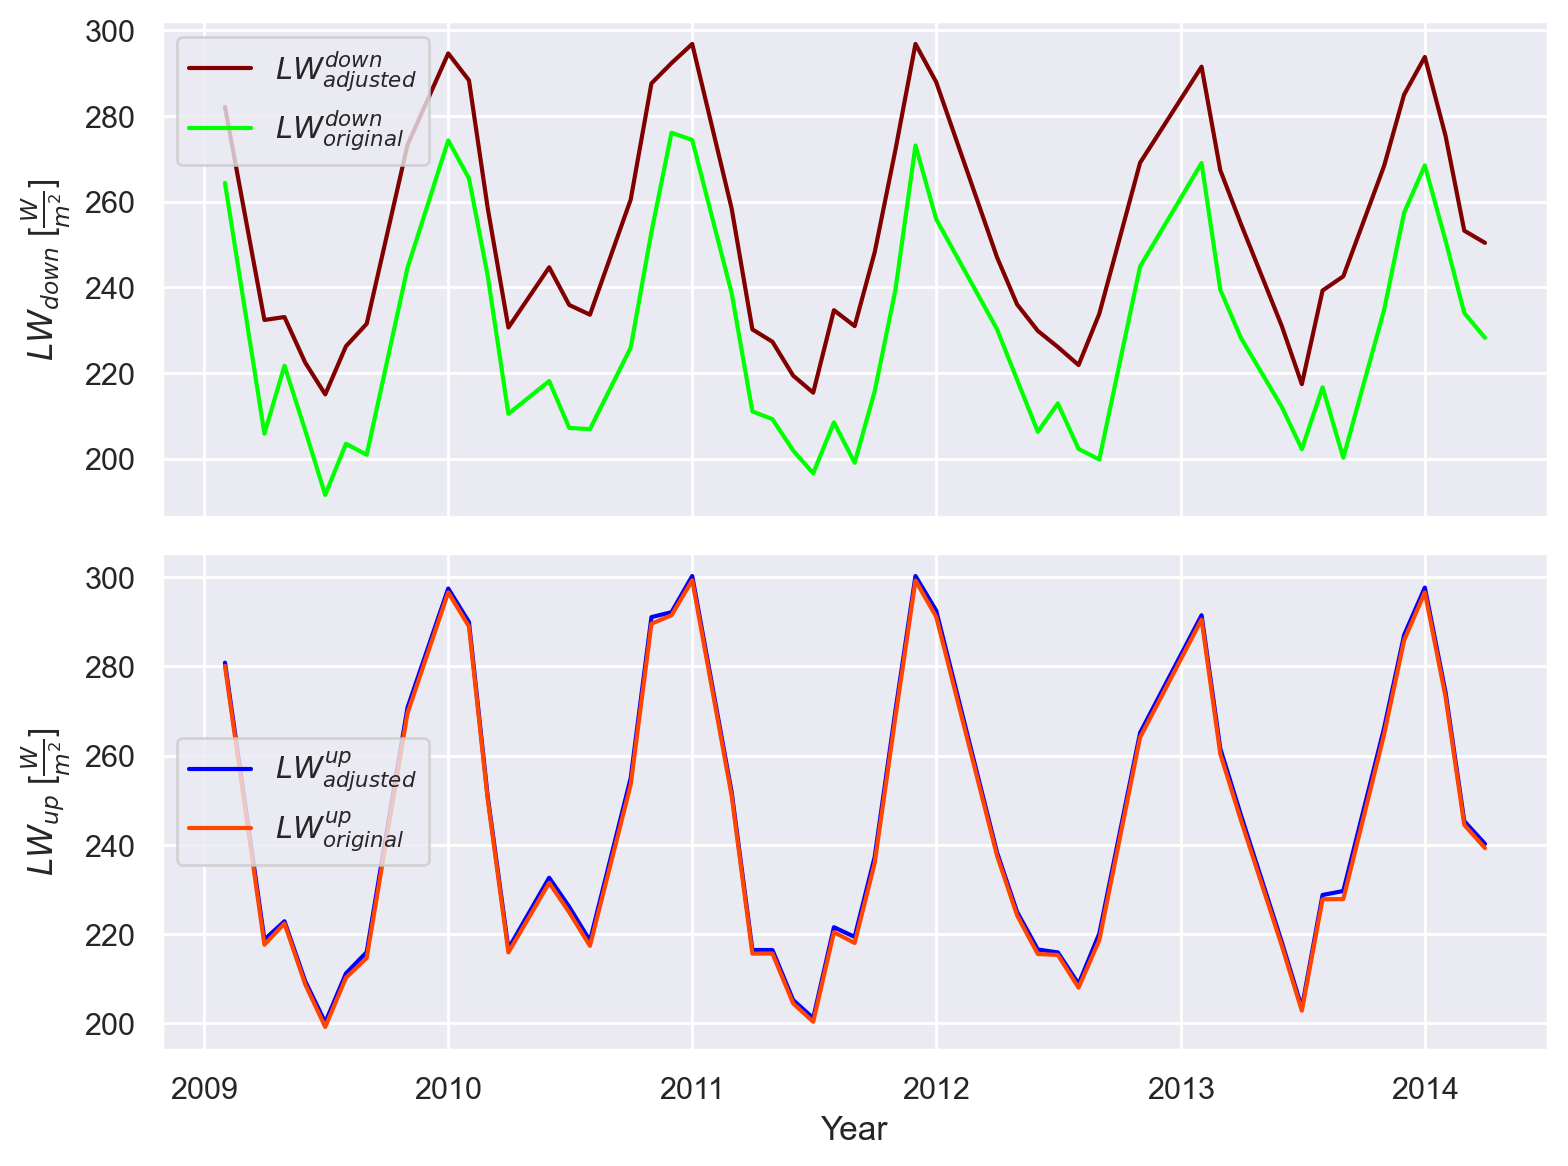

In [35]:
#plotting longwave radiation
fig, axs = plt.subplots(2,sharex=True,figsize=(8,6),dpi=200)
#fig.suptitle(f'Station: {station}, timestep:{timestep} ')
axs[0].set_ylabel(r'$LW_{down}$ [$\frac{W}{m^2}$]')
axs[0].plot(Time_data,LWdown,label=r'$LW^{down}_{adjusted}$',color='maroon')
axs[0].plot(Time_data,LWdown_original,label=r'$LW^{down}_{original}$',color='lime')
axs[0].legend()
axs[0].grid(True)
axs[1].set_ylabel(r'$LW_{up}$ [$\frac{W}{m^2}$]')
axs[1].plot(Time_data,LWup,label=r'$LW^{up}_{adjusted}$',color='blue')
axs[1].plot(Time_data,LWup_original,label=r'$LW^{up}_{original}$',color='orangered')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel(Time_Label)
#axs[1].set_xlim(Time_range)
plt.tight_layout()
plt.savefig(f"../results/figures/adjust-always-cloudy/LWdown_LWup_{timestep}.png")
plt.show()

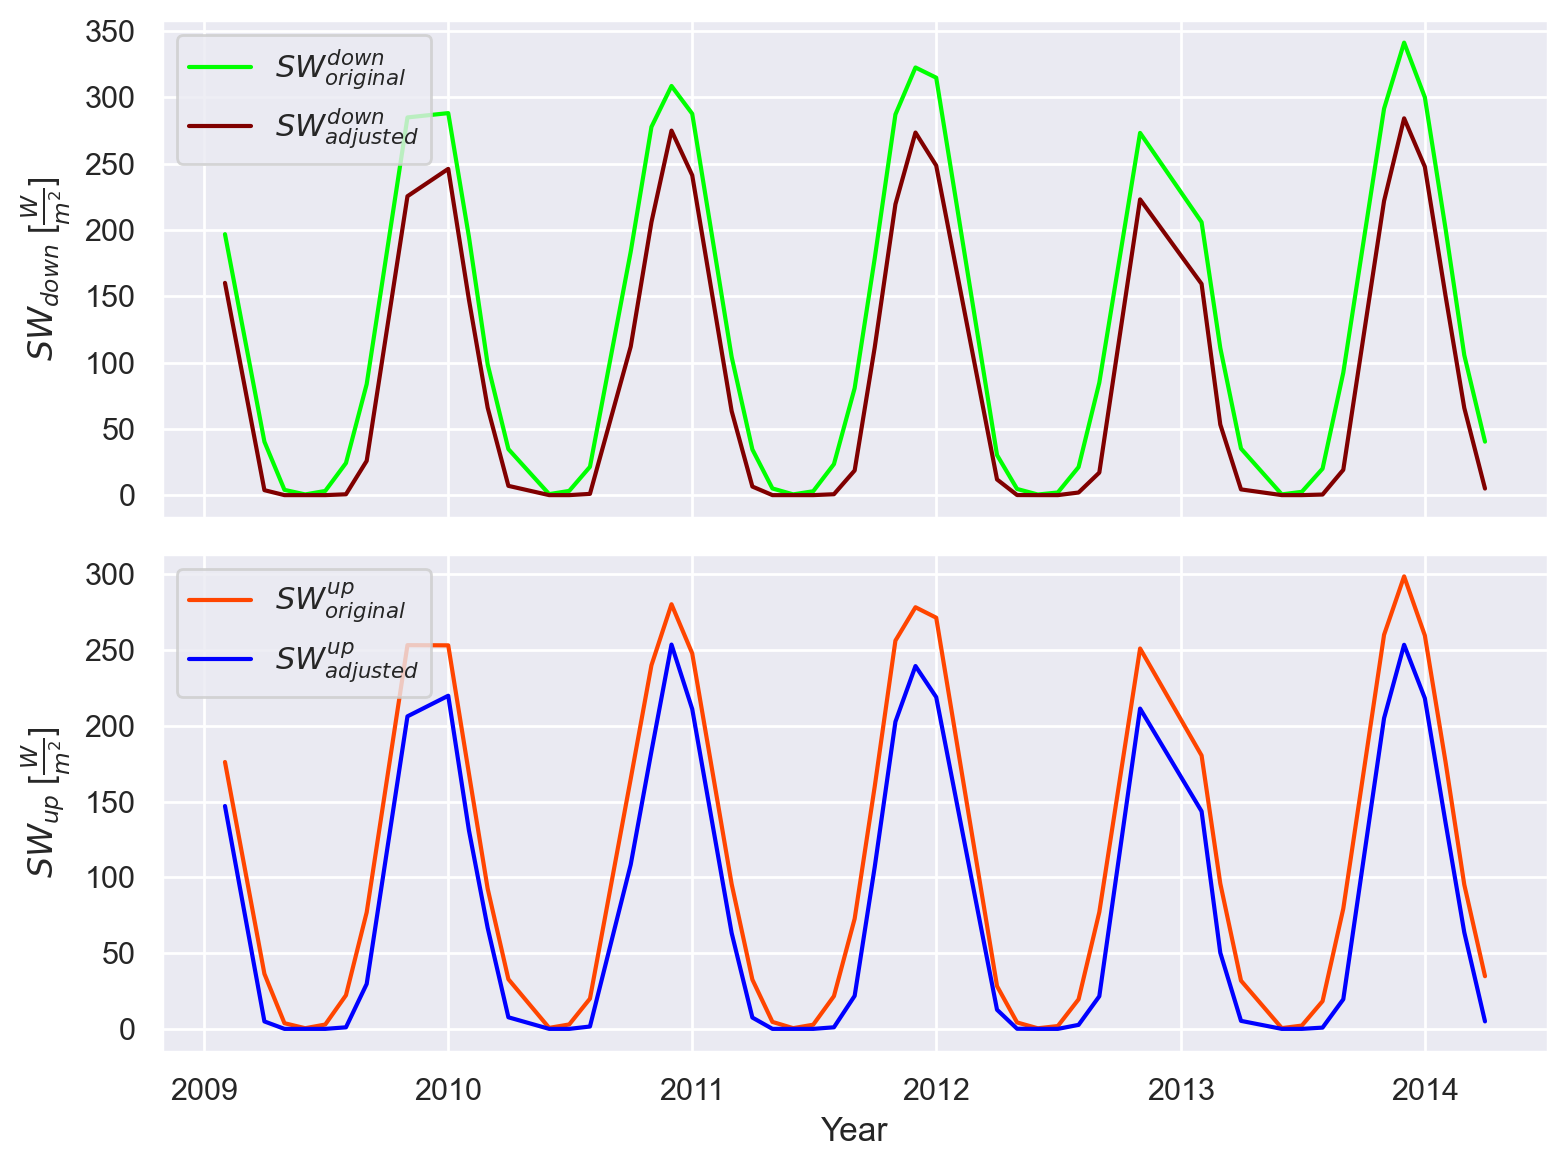

In [36]:
#plotting shortwave radiation
fig, axs = plt.subplots(2,sharex=True,figsize=(8,6),dpi=200)
#fig.suptitle(f'Station: {station}, timestep:{timestep} ')
axs[0].set_ylabel(r'$SW_{down}$ [$\frac{W}{m^2}$]')
axs[0].plot(Time_data,SWdown_original,label=r'$SW^{down}_{original}$',color='lime')
axs[0].plot(Time_data,SWdown,label=r'$SW^{down}_{adjusted}$',color='maroon')
axs[0].legend()
axs[0].grid(True)
axs[1].set_ylabel(r'$SW_{up}$ [$\frac{W}{m^2}$]')
axs[1].plot(Time_data,SWup_original,label=r'$SW^{up}_{original}$',color='orangered')
axs[1].plot(Time_data,SWup,label=r'$SW^{up}_{adjusted}$',color='blue')
axs[1].legend()
axs[1].grid(True)
axs[1].set_xlabel(Time_Label)
#axs[1].set_xlim(Time_range)
plt.tight_layout()
plt.savefig(f"../results/figures/adjust-always-cloudy/SWdown_SWup_{timestep}.png")
plt.show()